<a href="https://colab.research.google.com/github/sergioaugusto94/hello-world/blob/main/Crew_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

O objetivo desse trabalho é determinar a tripulação necessária para a operação de um navio, usando dados de entrada como tamanho, peso, capacidade de passageiros e idade do navio. Nesse trabalho foi usado a biblioteca pyspark juntamente com seu pacote de aprendizado de máquina.

# Carregamento do ambiente Spark e da base de dados

In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://ftp.unicamp.br/pub/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()


In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('crew_ship').getOrCreate()

In [ ]:
df = spark.read.csv('/content/cruise_ship_info.csv', header = True, inferSchema = True)

In [ ]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [ ]:
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Manipulação da Base de Dados

Vamos separar as colunas necessárias para realizar o treinamento do algoritmo. 
- Ship_name será descartada pois não possui nenhuma relação com o número de tripulantes necessários.
- Cruise_line é uma variável categórica, portanto, vamos convertê-la em uma variável discreta através da função StringIndexer. 

In [ ]:
df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

Fazendo a conversão da coluna categórica em uma coluna com valores discretos.

In [ ]:
stringIndexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_indexed",
    stringOrderType="frequencyDesc").fit(df)

df = stringIndexer.transform(df)

df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|                1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|                1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|                1.0|
+-----------+-----------+---+------------------+----------+-----

Vamos criar o vetor contendo as colunas com os atributos de entrada do algoritmo. O vetor é formato passado para a função que cria o algoritmo de Regressão na biblioteca pyspark.

In [ ]:
atributos = VectorAssembler(inputCols = ['Age', 'Tonnage', 'passengers', 
                                         'length', 'cabins', 'passenger_density', 'Cruise_line_indexed'], 
                            outputCol = 'features')

In [ ]:
#unido o vetor criado, ao dataframe inicial

saida = atributos.transform(df)

saida.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_line_indexed: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
saida.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|[6.0,30.276999999...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|[6.0,30.276999999...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|                1.0|[26.0,47.262,14.8...|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|                1.0|[11.0,110.0,29.74...|
|    Destiny|   Carnival| 17|     

Criação do Dataframe que será passado ao algoritmo de regressão, contendo as instâncias de entrada ('features') e outra coluna contendo os rótulos ('crew') de cada registro. 

In [ ]:
final_df = saida.select('features', 'crew')
final_df.show(3)

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
+--------------------+----+
only showing top 3 rows



Divisão da dataframe em treinamento e teste.

In [ ]:
train_data, test_data = final_df.randomSplit([0.7, 0.3])

# Treinamento e teste do algoritmo

Criação do algoritmo de regressão, passando a informação que a coluna contendo os valores rotulados se chama 'crew'.

In [ ]:
from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(labelCol='crew')

Treinamento do regressor, com o dataframe de treinamento.

In [ ]:
regressor = regressor.fit(train_data)

# Avaliação da performance do algoritmo

Vamos fazer agora a análise de alguns parâmetros estatísticos de forma a avaliar a performance do algoritmo.

In [ ]:
test_results = regressor.evaluate(test_data)

In [ ]:
test_results.r2

0.9564569312539687

In [ ]:
rmse = test_results.rootMeanSquaredError

rmse

0.716186640880709

In [ ]:
final_df.select('crew').describe().show()


+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [ ]:
mean = final_df.select('crew').describe()
mean = mean.select('crew').where(mean['summary'] == 'mean').collect()[0]['crew']
mean = float(mean)

rmse/mean

0.09188739505241825

A começar pelo coeficiente de determinação R2, quanto mais próximo de 1, melhor o modelo se ajusta à amostra estudada. No caso, temos o valor de 0.956, indicando que o regressor representa bem os dados apresentados. Agora comparando a média da coluna contendo os rótulos com o valor de rmse, vemos que rmse representa uma fração de 9% do valor médio. E ainda, o valor rmse é menor que o valor de desvio da amostra, indicando que é um bom modelo regressor.

# Deploiment

Vamos separar a coluna da base de teste contendo as entradas do algoritmo, que serão usadas para obtermos a resposta de saída do algoritmo. 

In [ ]:
inputs = test_data.select('features')

inputs.show(5)

+--------------------+
|            features|
+--------------------+
|[5.0,160.0,36.34,...|
|[6.0,30.276999999...|
|[6.0,93.0,23.94,9...|
|[6.0,110.23899999...|
|[6.0,112.0,38.0,9...|
+--------------------+
only showing top 5 rows



In [ ]:
prediction = regressor.transform(inputs)

prediction.show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,160.0,36.34,...|15.320764664059716|
|[6.0,30.276999999...| 4.401680978331521|
|[6.0,93.0,23.94,9...|10.714684059314152|
|[6.0,110.23899999...|11.224410054302744|
|[6.0,112.0,38.0,9...|11.435591218401935|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
test_data.show(5)

+--------------------+-----+
|            features| crew|
+--------------------+-----+
|[5.0,160.0,36.34,...| 13.6|
|[6.0,30.276999999...| 3.55|
|[6.0,93.0,23.94,9...|11.09|
|[6.0,110.23899999...| 11.5|
|[6.0,112.0,38.0,9...| 10.9|
+--------------------+-----+
only showing top 5 rows



In [ ]:
prediction = prediction.select('prediction').collect()
previsao = []
for row in prediction:
  previsao.append(row[0])

test_data1 = test_data.select('crew').collect()
rotulos = []
for row in test_data1:
  rotulos.append(row[0])

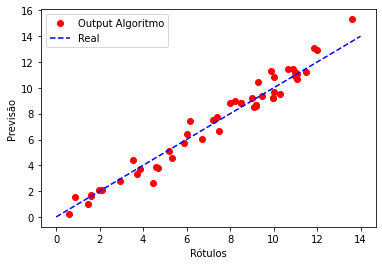

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rotulos, previsao, 'ro', [0,14], [0,14], 'b--')
plt.legend(['Output Algoritmo', 'Real'])
plt.xlabel('Rótulos')
plt.ylabel('Previsão')
plt.show()

Visualmente o modelo se comporta muito bem ao prever a quantidade de tripulantes.